# Tight Bounds for Binomial

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
from scipy.stats import norm, beta
import matplotlib.pyplot as plt

This notebook studies the behavior of a collection of bounds in a simple binomial test setting.
Consider $X \sim Binom(n, p(\theta))$ where $n$ is fixed, $\theta \in \mathbb{R}$ is the natural parameter,
and $p(\theta)$ is the sigmoid function.
For a fixed critical threshold $t^*$, we reject if $X > t^*$.

## Taylor Bound

In [2]:
def f(theta, n, t):
    return scipy.stats.binom.sf(t, n, scipy.special.expit(theta))
    
def df(theta, n, t):
    p = scipy.special.expit(theta)
    return scipy.stats.binom.expect(
        lambda x: (x > t) * (x - n*p),
        args=(n, p),
    )

In [3]:
def taylor_bound(f0, df0, vs, theta_0, n):
    p = scipy.special.expit(theta_0)
    return f0 + df0 * vs + 0.5 * vs**2 * n * p * (1-p)

## Centered Holder Bound

In [4]:
At = lambda t, n: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, n, x: t * x - At(t, n)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, None, 0))

In [5]:
def copt(a, p):
    return 1 / (1 + ((1-a)/a)**(1/(p-1)))

def C_numerical(n_arm_samples, t, hp, hq):
    p = scipy.special.expit(t)
    xs = np.arange(n_arm_samples + 1).astype(np.float64)
    eggq = np.abs(dg_vmap(t, n_arm_samples, xs)) ** hq
    return sum(eggq * scipy.stats.binom.pmf(xs, n_arm_samples, p)) ** (1 / hq)
    
def holder_bound(f0, n_arm_samples, t_path, hp, hc='opt'):
    if hc == 'opt':
        hc_func = copt
    else:
        hc_func = lambda a, p: hc
    hq = 1 / (1 - 1 / hp)

    def derivs(t, y):
        cur_f = y[0]
        c = hc_func(cur_f, hp)
        cur_Fc = cur_f * (1 - c) ** hp + (1 - cur_f) * c ** hp
        return C_numerical(n_arm_samples, t, hp, hq) * cur_Fc ** (1 / hp)
    
    t = t_path[0] 
    dt = t_path[-1] - t
    centeredode = scipy.integrate.solve_ivp(derivs, (t, t+dt), [f0], t_eval=t_path, rtol=1e-10, atol=1e-10)
    return centeredode['y'][0]

## Performance Comparison

In [6]:
theta_0 = -1
n = 350
v_max = 1
n_steps = 20
thresh = 110

In [7]:
f0 = f(theta_0, n, thresh)
df0 = df(theta_0, n, thresh)
vs = np.linspace(0, v_max, n_steps)

In [8]:
def run(theta_0, n, f0, df0, vs, thresh, hp, hc):
    # compute true Type I Error
    thetas = theta_0 + vs
    fs = f(thetas, n, thresh)

    # compute taylor bound
    taylor_bounds = taylor_bound(f0, df0, vs, theta_0, n)

    # compute holder centered bound
    holder_bounds = [holder_bound(f0, n, vs, hp, c) for c in hc]
    
    # compute exp holder impr bound
    #exp_holder_impr_bounds = exp_holder_impr_bound(f0, vs)

    # plot everything
    plt.plot(thetas, fs, ls='--', color='black', label='True TIE')
    plt.plot(thetas, taylor_bounds, ls='-', label='taylor')
    #for i, c in enumerate(hc):
    #    plt.plot(thetas, holder_bounds[i], ls='--', label=f'centered-holder({c}), p={hp}')
    #plt.plot(thetas, exp_holder_impr_bounds, ls=':', label='exp-holder-impr')
    plt.legend()
    plt.show()

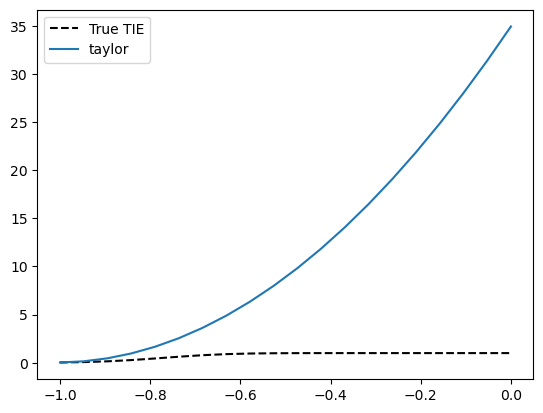

In [9]:
run(
    theta_0=theta_0,
    n=n,
    f0=f0,
    df0=df0,
    vs=vs,
    thresh=thresh,
    hp=2,
    hc=[0, 0.2, 0.4, 0.6, 0.8, 1, 'opt'],
)